In [ ]:
# %%

# IMPORT
# ==============================================================================================
import math
import numpy as np
import cv2
import imageio as iio
import skimage.measure as measure
from matplotlib import pyplot as plt

In [ ]:
# %%

# FUNCTIONS
# ==============================================================================================
def calculate_circularity(area, perimeter):
  circularity = (4 * math.pi * area) / (perimeter * perimeter)
  return circularity


def dilate_mask(mask_raw, dilatation_size=5, dilation_shape=cv2.MORPH_ELLIPSE):
    element = cv2.getStructuringElement(dilation_shape, (2 * dilatation_size + 1, 2 * dilatation_size + 1), (dilatation_size, dilatation_size))
    mask_dilated = cv2.dilate(mask_raw, element)
    return mask_dilated



def filter_mask_1(im_gray, mask_raw):
    mask_label = measure.label(mask_raw)
    props_tab = measure.regionprops_table(mask_label, properties=('centroid', 'area', 'perimeter'))

    area_level = [40, 140]
    perimeter_level = [200, 250]
    circularity_level = [0.85, 10]

    circularity = calculate_circularity(props_tab['area'], props_tab['perimeter'])

    id_area = (props_tab['area']>=area_level[0]) * (props_tab['area']<=area_level[1])
    id_circularity = (circularity>=circularity_level[0]) * (circularity<=circularity_level[1])
    id_keep = id_area * id_circularity

    mask_label_new = mask_label.copy()

    ids = np.unique(mask_label)
    ids = ids[1:] # ignore background value 0

    for i in range(ids.shape[0]):
        
        tem = (mask_label==ids[i])
        tem_2 = tem * im_gray

        if (not id_keep[i]) or (tem_2.max() < 215): # filter by area and intensity
            tem = tem * ids[i]
            mask_label_new  = mask_label_new  - tem
            
    # plt.imshow(mask_label_new)
            
    mask_output = (mask_label_new > 0).astype(np.uint8)
            
    return mask_output




def filter_mask_2(mask_raw):
    mask_label = measure.label(mask_raw)
    props_tab = measure.regionprops_table(mask_label, properties=('centroid',))

    sum_x_direction = np.sum(mask_raw, axis=1)

    mask_label_new = mask_label.copy()

    ids = np.unique(mask_label)

    for i in range(1, ids.shape[0]):
        
        center_y = int(props_tab['centroid-0'][i-1])
        
        if sum_x_direction[center_y] < mask_raw.shape[0]/4:
        
            tem = (mask_label==ids[i])
            tem = tem * ids[i]
            
            mask_label_new = mask_label_new - tem
            
    # plt.imshow(mask_label_new)        
    mask_output = (mask_label_new > 0).astype(np.uint8)
            
    return mask_output

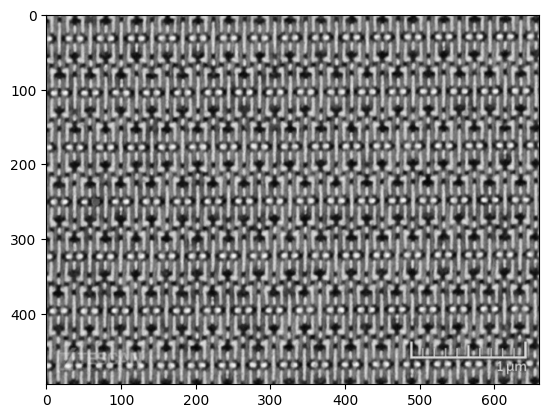

In [ ]:
# %%

# READ IMAGE
# ==============================================================================================
image = cv2.imread('Inputs/Sample image.png')
im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(im_gray, cmap='gray')
plt.show()

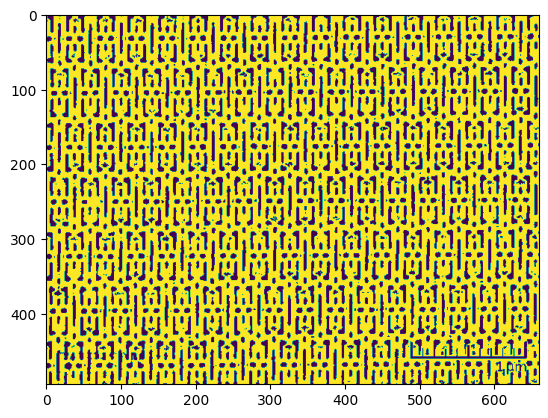

In [ ]:
# %%

# THESHOLD IMAGE TO GENERATE RAW MASK
# ==============================================================================================
lowers = np.array([20])
highers = np.array([150])
mask_raw_1 = cv2.inRange(im_gray, lowers, highers)
plt.imshow(mask_raw_1)
plt.show()

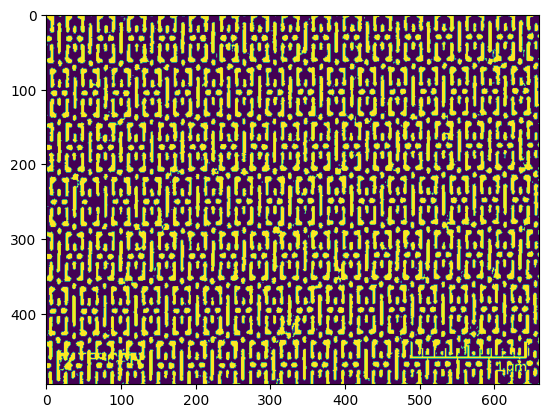

In [ ]:
# %%

lowers = np.array([130])
highers = np.array([255])
mask_raw_2 = cv2.inRange(im_gray, lowers, highers)
plt.imshow(mask_raw_2)
plt.show()

<ipython-input-2-b41f785dd322>:5: RuntimeWarning: divide by zero encountered in divide
  circularity = (4 * math.pi * area) / (perimeter * perimeter)


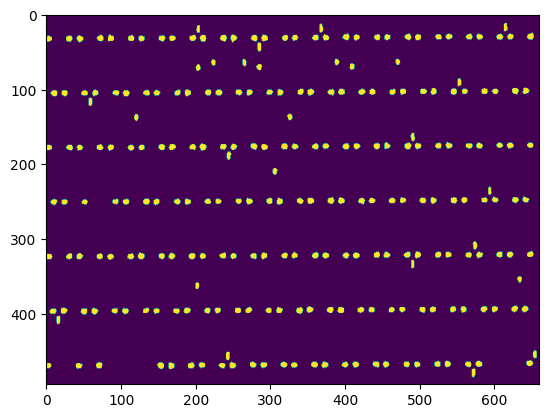

In [ ]:
# %%

# FILTER RAW MASK
# ==============================================================================================
# Filter mask_raw for 1st time
mask_clean_1 = filter_mask_1(im_gray, mask_raw_2)
plt.imshow(mask_clean_1)
plt.show()

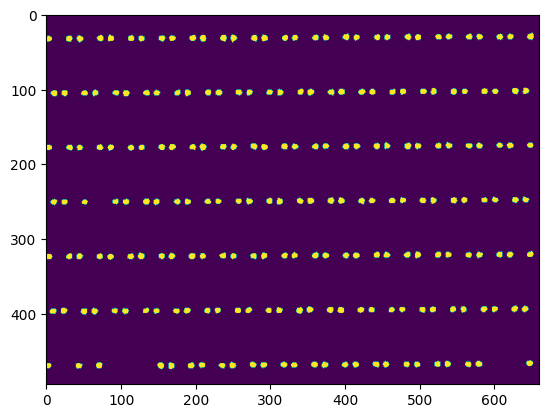

In [ ]:
# %%

# Filter mask_raw for 2nd time
mask_clean_2 = filter_mask_2(mask_clean_1)
plt.figure()
plt.imshow(mask_clean_2)
plt.show() 

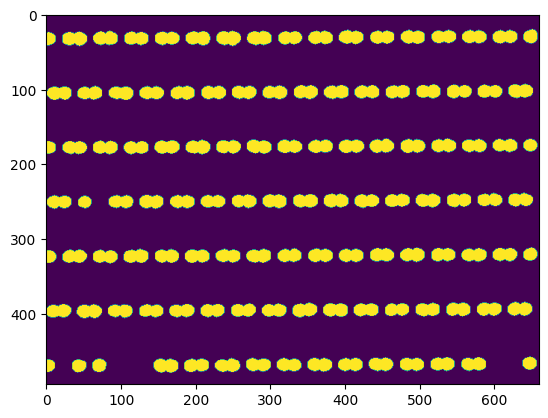

In [ ]:
# %%

# Dilate filtered mask
dilatation_size = 5
dilation_shape = cv2.MORPH_ELLIPSE
mask_dilated = dilate_mask(mask_clean_2, dilatation_size, dilation_shape)
plt.imshow(mask_dilated)
plt.show() 

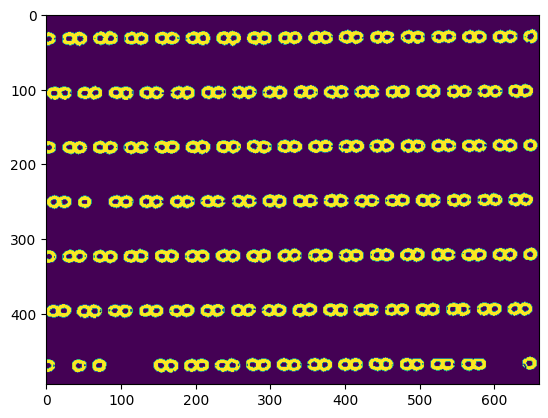

In [ ]:
# %%

# Combine mask
mask_combined = (mask_raw_1 * mask_dilated) / 255
iio.imwrite('Outputs/mask_combined.tif', mask_combined.astype(np.uint8)*255)
plt.imshow(mask_combined)
plt.show()  

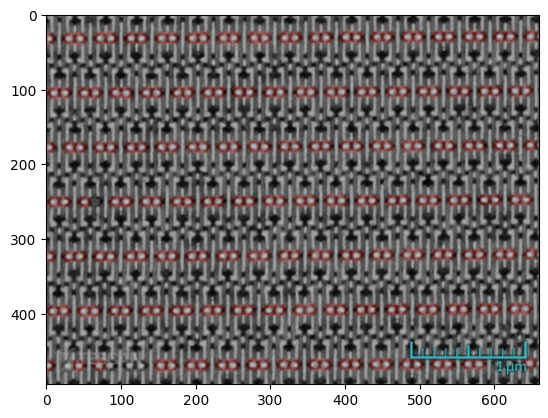

In [ ]:
# %%

# OVERLAY MASK ON IMAGE
# ==============================================================================================
mask_color = np.zeros([mask_combined.shape[0], mask_combined.shape[1], 3]).astype(np.uint8)
mask_color[:, :, 0] = mask_combined * 255

alpha = 0.8
im_overlay = cv2.addWeighted(image, alpha, mask_color, 1-alpha, 0) 
iio.imwrite('Outputs/im_overlay.png', im_overlay)
plt.imshow(im_overlay)
plt.show()  

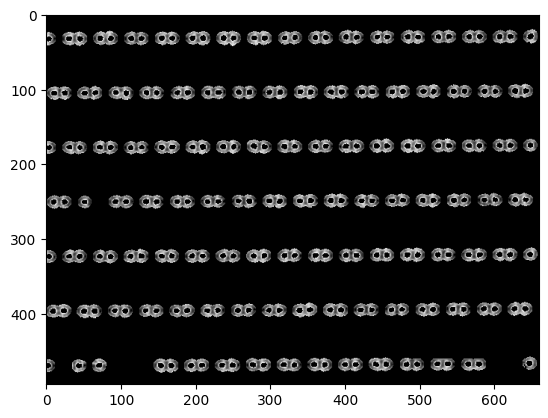

In [ ]:
# %%

# APPLY MASK TO IMAGE
# ==============================================================================================
im_segment = (mask_combined * im_gray).astype(np.uint8)
iio.imwrite('Outputs/im_segment.png', im_segment)
plt.imshow(im_segment, cmap='gray')
plt.show()  

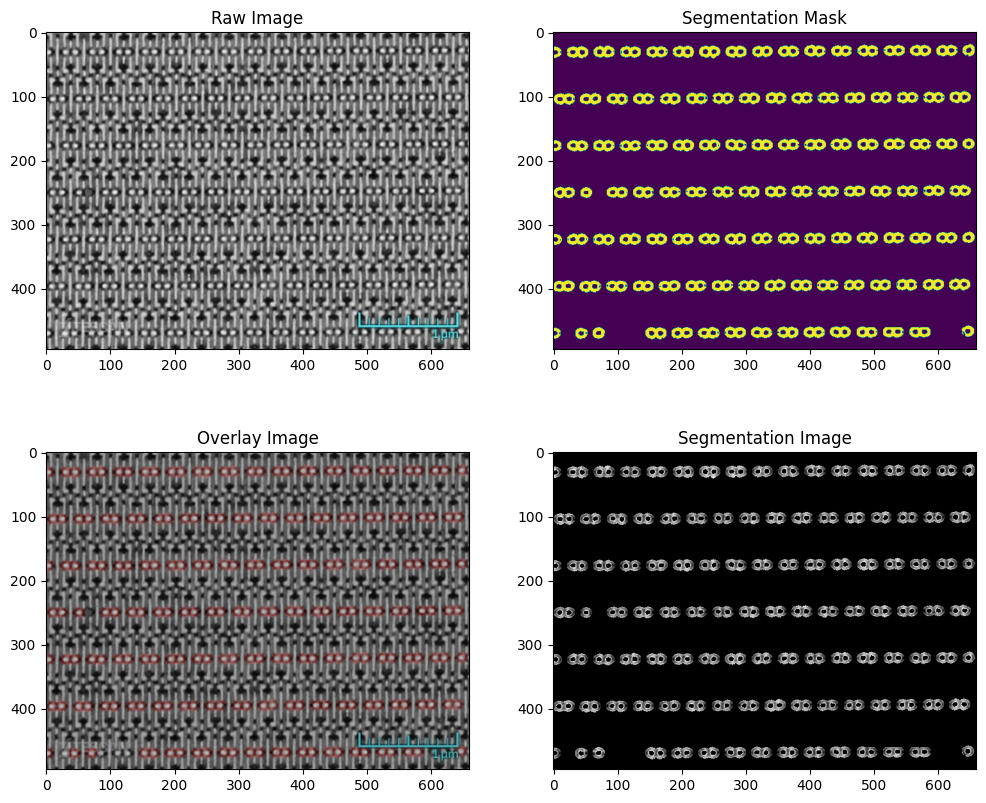

In [ ]:
# %%

# APPLY MASK TO IMAGE
# ==============================================================================================
fig = plt.figure(figsize=(12, 10))
                
# plt.rcParams.update({'font.size': 16})
plt.subplot(2, 2, 1); plt.imshow(image)
plt.title('Raw Image')

plt.subplot(2, 2, 2); plt.imshow(mask_combined)
plt.title('Segmentation Mask')

plt.subplot(2, 2, 3); plt.imshow(im_overlay)
plt.title('Overlay Image')

plt.subplot(2, 2, 4); plt.imshow(im_segment, cmap='gray')
plt.title('Segmentation Image')

plt.savefig('Outputs/im_all.png')

plt.show()